# TensorFlow script mode training and serving

Script mode is a training script format for TensorFlow that lets you execute any TensorFlow training script in SageMaker with minimal modification. The [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) handles transferring your script to a SageMaker training instance. On the training instance, SageMaker's native TensorFlow support sets up training-related environment variables and executes your training script. In this tutorial, we use the SageMaker Python SDK to launch a training job and deploy the trained model.

Script mode supports training with a Python script, a Python module, or a shell script. In this example, we use a Python script to train a classification model on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). In this example, we will show how easily you can train a SageMaker using TensorFlow 1.x and TensorFlow 2.0 scripts with SageMaker Python SDK. In addition, this notebook demonstrates how to perform real time inference with the [SageMaker TensorFlow Serving container](https://github.com/aws/sagemaker-tensorflow-serving-container). The TensorFlow Serving container is the default inference method for script mode. For full documentation on the TensorFlow Serving container, please visit [here](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/deploying_tensorflow_serving.rst).


# Set up the environment

Let's start by setting up the environment:

In [15]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

## Training Data

The MNIST dataset has been loaded to the public S3 buckets ``sagemaker-sample-data-<REGION>`` under the prefix ``tensorflow/mnist``. There are four ``.npy`` file under this prefix:
* ``train_data.npy``
* ``eval_data.npy``
* ``train_labels.npy``
* ``eval_labels.npy``

In [16]:
training_data_uri = 's3://sagemaker-sample-data-{}/tensorflow/mnist'.format(region)

# Construct a script for distributed training

This tutorial's training script was adapted from TensorFlow's official [CNN MNIST example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/layers/cnn_mnist.py). We have modified it to handle the ``model_dir`` parameter passed in by SageMaker. This is an S3 path which can be used for data sharing during distributed training and checkpointing and/or model persistence. We have also added an argument-parsing function to handle processing training-related variables.

At the end of the training job we have added a step to export the trained model to the path stored in the environment variable ``SM_MODEL_DIR``, which always points to ``/opt/ml/model``. This is critical because SageMaker uploads all the model artifacts in this folder to S3 at end of training.

Here is the entire script:

In [17]:
#!pygmentize 'mnist.py'

# TensorFlow 2.0 script
#!pygmentize 'mnist-2.py'

# Create a training job using the `TensorFlow` estimator

The `sagemaker.tensorflow.TensorFlow` estimator handles locating the script mode container, uploading your script to a S3 location and creating a SageMaker training job. Let's call out a couple important parameters here:

* `py_version` is set to `'py3'` to indicate that we are using script mode since legacy mode supports only Python 2. Though Python 2 will be deprecated soon, you can use script mode with Python 2 by setting `py_version` to `'py2'` and `script_mode` to `True`.

* `distributions` is used to configure the distributed training setup. It's required only if you are doing distributed training either across a cluster of instances or across multiple GPUs. Here we are using parameter servers as the distributed training schema. SageMaker training jobs run on homogeneous clusters. To make parameter server more performant in the SageMaker setup, we run a parameter server on every instance in the cluster, so there is no need to specify the number of parameter servers to launch. Script mode also supports distributed training with [Horovod](https://github.com/horovod/horovod). You can find the full documentation on how to configure `distributions` [here](https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/tensorflow#distributed-training). 



In [18]:
from sagemaker.tensorflow import TensorFlow

mnist_estimator = TensorFlow(entry_point='mnist.py',
                             role=role,
                             train_instance_count=2,
                             train_instance_type='ml.p3.2xlarge',
                             framework_version='1.14',
                             py_version='py3',
                             distributions={'parameter_server': {'enabled': True}})

You can also initiate an estimator to train with TensorFlow 2.0 script. The only things that you will need to change are the script name and ``framework_version``

In [19]:
mnist_estimator2 = TensorFlow(entry_point='mnist-2.py',
                             role=role,
                             train_instance_count=2,
                             train_instance_type='ml.p3.2xlarge',
                             framework_version='2.0.0',
                             py_version='py3',
                             distributions={'parameter_server': {'enabled': True}})

## Calling ``fit``

To start a training job, we call `estimator.fit(training_data_uri)`.

An S3 location is used here as the input. `fit` creates a default channel named `'training'`, which points to this S3 location. In the training script we can then access the training data from the location stored in `SM_CHANNEL_TRAINING`. `fit` accepts a couple other types of input as well. See the API doc [here](https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.EstimatorBase.fit) for details.

When training starts, the TensorFlow container executes mnist.py, passing `hyperparameters` and `model_dir` from the estimator as script arguments. Because we didn't define either in this example, no hyperparameters are passed, and `model_dir` defaults to `s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>`, so the script execution is as follows:
```bash
python mnist.py --model_dir s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>
```
When training is complete, the training job will upload the saved model for TensorFlow serving.

In [20]:
mnist_estimator.fit(training_data_uri)

2020-03-30 23:37:48 Starting - Starting the training job...
2020-03-30 23:37:49 Starting - Launching requested ML instances.........
2020-03-30 23:39:20 Starting - Preparing the instances for training......
2020-03-30 23:40:31 Downloading - Downloading input data...
2020-03-30 23:41:01 Training - Downloading the training image./usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: Fu


2020-03-30 23:41:28 Training - Training image download completed. Training in progress./usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-

W0330 23:47:49.500113 139650721416960 deprecation_wrapper.py:119] From mnist.py:115: The name tf.metrics.accuracy is deprecated. Please use tf.compat.v1.metrics.accuracy instead.

W0330 23:47:49.639260 139650721416960 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1282: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
W0330 23:47:50.919890 139650721416960 deprecation.py:323] From mnist.py:184: Estimator.export_savedmodel (from tensorflow_estimator.python.estimator.estimator) is deprecated and will be removed in a future version.
Instructions for updating:
This function has been renamed, use `export_saved_model` instead.
W0330 23:47:51.134563 139650721416960 deprecation_wrapper.py:119] From mnist.py:145: The name tf.placeholder is deprecated. Please use tf.compat.v1.plac

Calling fit to train a model with TensorFlow 2.0 scroipt.

In [21]:
mnist_estimator2.fit(training_data_uri)

2020-03-30 23:49:38 Starting - Starting the training job...
2020-03-30 23:49:40 Starting - Launching requested ML instances......
2020-03-30 23:50:43 Starting - Preparing the instances for training......
2020-03-30 23:51:54 Downloading - Downloading input data...
2020-03-30 23:52:21 Training - Downloading the training image..2020-03-30 23:52:45,960 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-03-30 23:52:46,184 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2020-03-30 23:52:46,184 sagemaker_tensorflow_container.training INFO     Launching parameter server process
2020-03-30 23:52:46,184 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2020-03-30 23:52:46,676 sagemaker_tensorflow_container.training INFO     Launching worker process
2020-03-30 23:52:46,982 sagemaker-containers INFO     Invoking user script

Training Env:

{
   


2020-03-30 23:52:42 Training - Training image download completed. Training in progress.Train on 55000 samples
#015   32/55000 [..............................] - ETA: 40:20 - loss: 2.2745 - accuracy: 0.1250#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  736/55000 [..............................] - ETA: 1:47 - loss: 1.2807 - accuracy: 0.6332 #010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01

Train on 55000 samples
#015   32/55000 [..............................] - ETA: 33:39 - loss: 2.3860 - accuracy: 0.1250#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  704/55000 [..............................] - ETA: 1:34 - loss: 1.2740 - accuracy: 0.6335 #010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1408/55000 [..............................] - ETA: 48s - l


2020-03-30 23:59:05 Uploading - Uploading generated training model
2020-03-30 23:59:05 Completed - Training job completed
Training seconds: 862
Billable seconds: 862


# Deploy the trained model to an endpoint

The `deploy()` method creates a SageMaker model, which is then deployed to an endpoint to serve prediction requests in real time. We will use the TensorFlow Serving container for the endpoint, because we trained with script mode. This serving container runs an implementation of a web server that is compatible with SageMaker hosting protocol. The [Using your own inference code]() document explains how SageMaker runs inference containers.

In [22]:
predictor = mnist_estimator.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

---------------!

Deployed the trained TensorFlow 2.0 model to an endpoint.

In [23]:
predictor2 = mnist_estimator2.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

---------------!

# Invoke the endpoint

Let's download the training data and use that as input for inference.

In [24]:
import numpy as np

!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/train_data.npy train_data.npy
!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/train_labels.npy train_labels.npy

train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')

download: s3://sagemaker-sample-data-us-east-1/tensorflow/mnist/train_data.npy to ./train_data.npy
download: s3://sagemaker-sample-data-us-east-1/tensorflow/mnist/train_labels.npy to ./train_labels.npy


The formats of the input and the output data correspond directly to the request and response formats of the `Predict` method in the [TensorFlow Serving REST API](https://www.tensorflow.org/serving/api_rest). SageMaker's TensforFlow Serving endpoints can also accept additional input formats that are not part of the TensorFlow REST API, including the simplified JSON format, line-delimited JSON objects ("jsons" or "jsonlines"), and CSV data.

In this example we are using a `numpy` array as input, which will be serialized into the simplified JSON format. In addtion, TensorFlow serving can also process multiple items at once as you can see in the following code. You can find the complete documentation on how to make predictions against a TensorFlow serving SageMaker endpoint [here](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/deploying_tensorflow_serving.rst#making-predictions-against-a-sagemaker-endpoint).

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
    
def plot_mnist(input_tensor):
    fig, ax = plt.subplots()
    ax.imshow(input_tensor, cmap=plt.cm.gray)
    ax.set_axis_off()
    plt.title("MNIST Image ")
    plt.axis('off')
    plt.show()

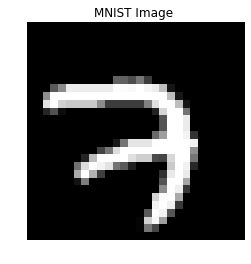

prediction is 7, label is 7, matched: True


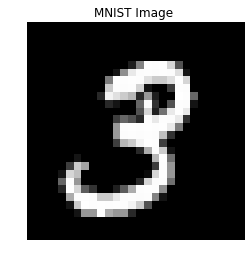

prediction is 3, label is 3, matched: True


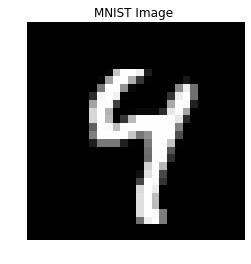

prediction is 4, label is 4, matched: True


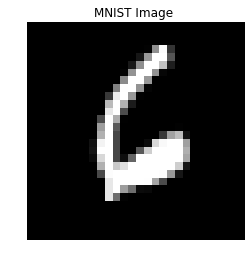

prediction is 6, label is 6, matched: True


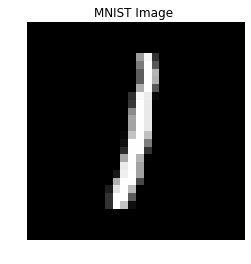

prediction is 1, label is 1, matched: True


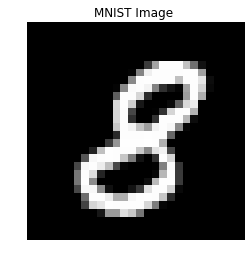

prediction is 8, label is 8, matched: True


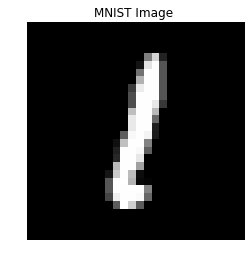

prediction is 1, label is 1, matched: True


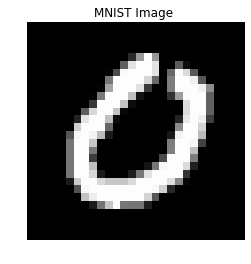

prediction is 0, label is 0, matched: True


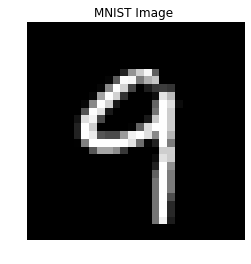

prediction is 9, label is 9, matched: True


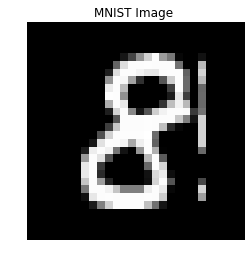

prediction is 8, label is 8, matched: True


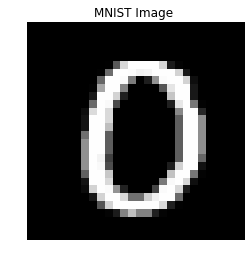

prediction is 0, label is 0, matched: True


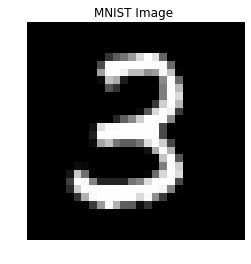

prediction is 3, label is 3, matched: True


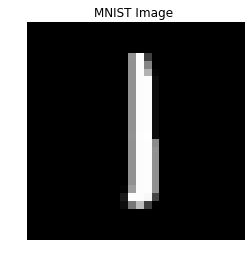

prediction is 1, label is 1, matched: True


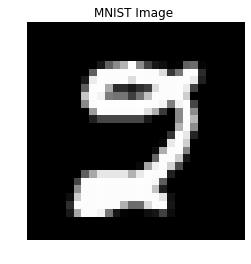

prediction is 3, label is 2, matched: False


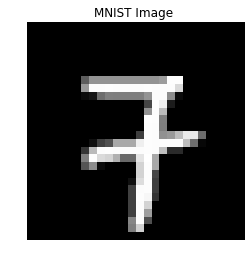

prediction is 7, label is 7, matched: True


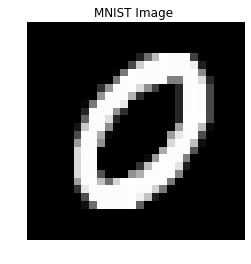

prediction is 0, label is 0, matched: True


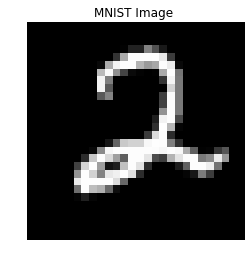

prediction is 2, label is 2, matched: True


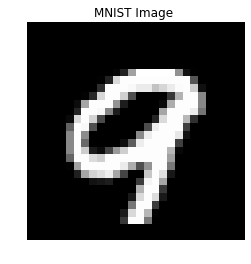

prediction is 9, label is 9, matched: True


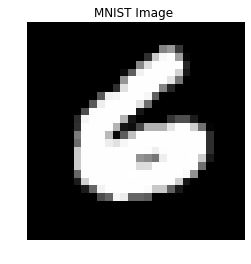

prediction is 6, label is 6, matched: True


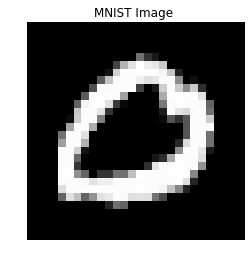

prediction is 0, label is 0, matched: True


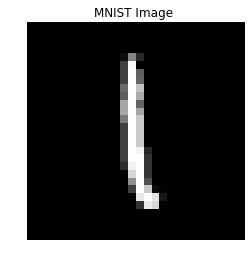

prediction is 1, label is 1, matched: True


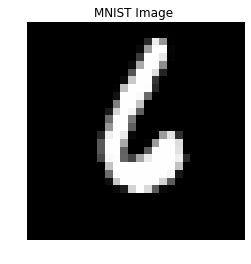

prediction is 6, label is 6, matched: True


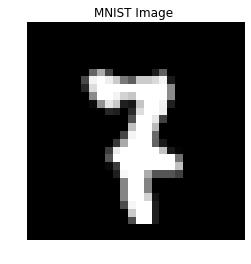

prediction is 7, label is 7, matched: True


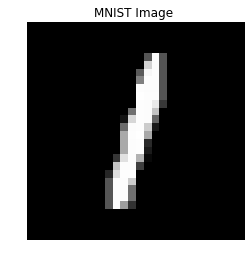

prediction is 1, label is 1, matched: True


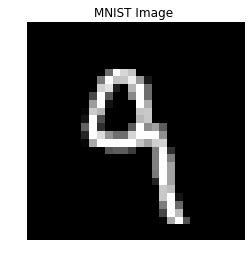

prediction is 9, label is 9, matched: True


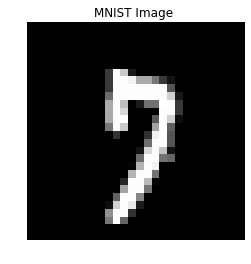

prediction is 7, label is 7, matched: True


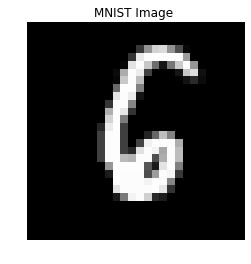

prediction is 6, label is 6, matched: True


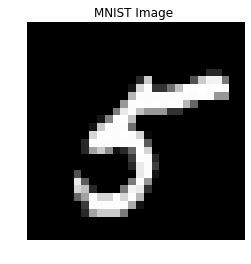

prediction is 5, label is 5, matched: True


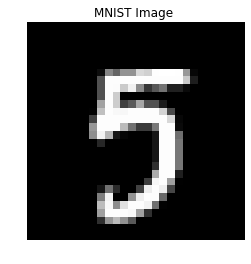

prediction is 5, label is 5, matched: True


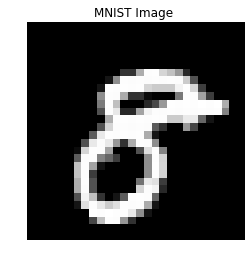

prediction is 8, label is 8, matched: True


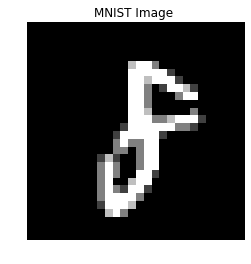

prediction is 8, label is 8, matched: True


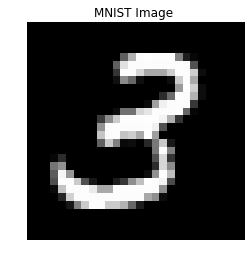

prediction is 3, label is 3, matched: True


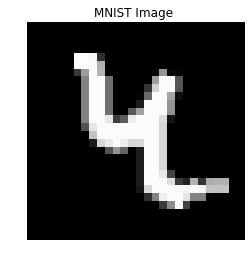

prediction is 4, label is 4, matched: True


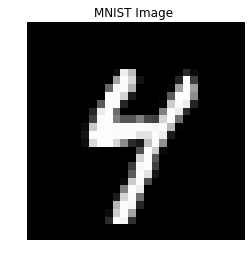

prediction is 4, label is 4, matched: True


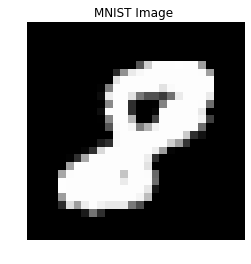

prediction is 8, label is 8, matched: True


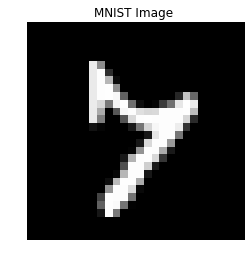

prediction is 7, label is 7, matched: True


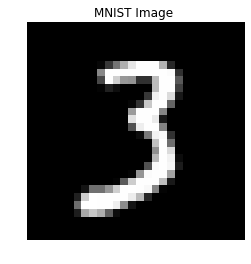

prediction is 3, label is 3, matched: True


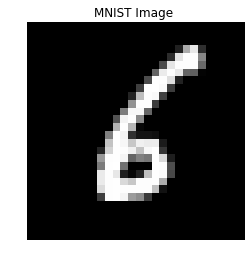

prediction is 6, label is 6, matched: True


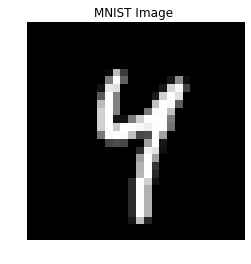

prediction is 4, label is 4, matched: True


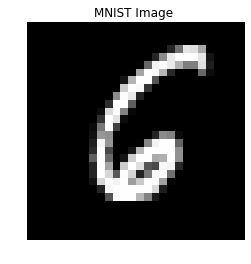

prediction is 6, label is 6, matched: True


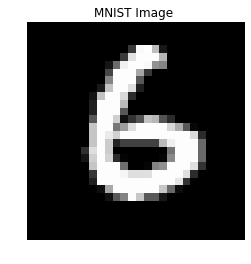

prediction is 6, label is 6, matched: True


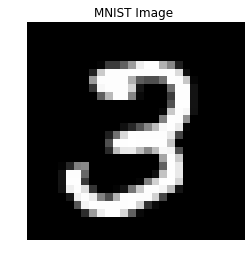

prediction is 3, label is 3, matched: True


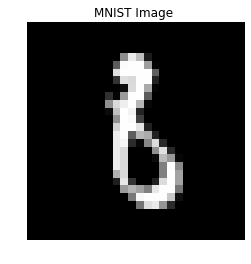

prediction is 1, label is 8, matched: False


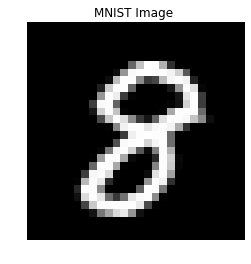

prediction is 8, label is 8, matched: True


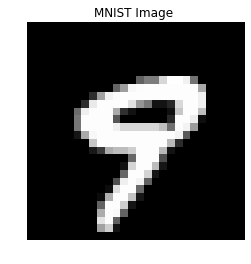

prediction is 9, label is 9, matched: True


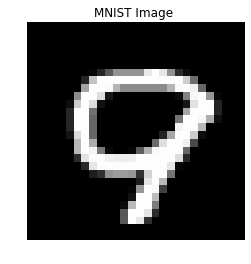

prediction is 9, label is 9, matched: True


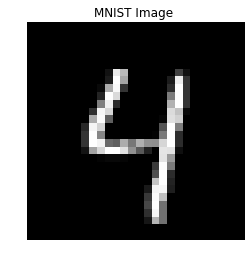

prediction is 4, label is 4, matched: True


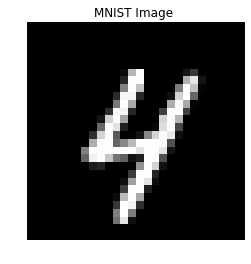

prediction is 4, label is 4, matched: True


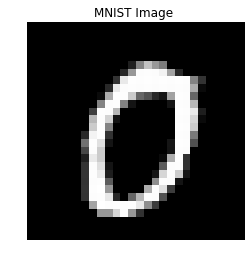

prediction is 0, label is 0, matched: True


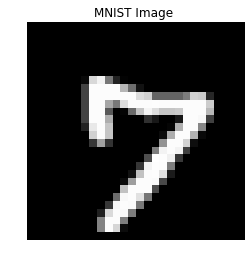

prediction is 7, label is 7, matched: True


In [30]:
predictions = predictor.predict(train_data[:50])
for i in range(0, 50):
    prediction = predictions['predictions'][i]['classes']
    label = train_labels[i]
    mnist_image=train_data[i].reshape((28,28))
    plot_mnist(mnist_image)
    print('prediction is {}, label is {}, matched: {}'.format(prediction, label, prediction == label))

Examine the prediction result from the TensorFlow 2.0 model.

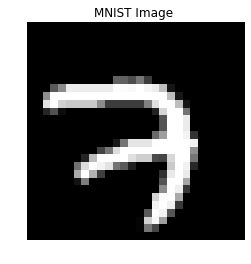

prediction is 7, label is 7, matched: True


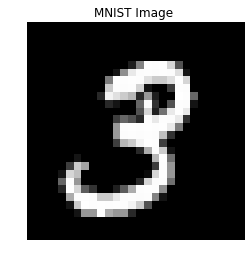

prediction is 3, label is 3, matched: True


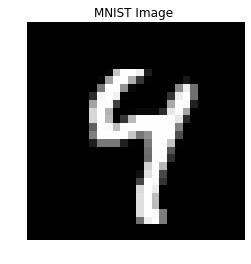

prediction is 9, label is 4, matched: False


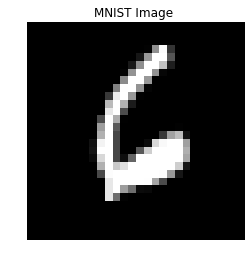

prediction is 6, label is 6, matched: True


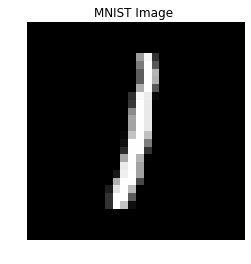

prediction is 1, label is 1, matched: True


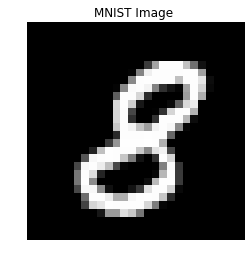

prediction is 8, label is 8, matched: True


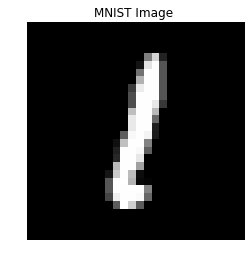

prediction is 1, label is 1, matched: True


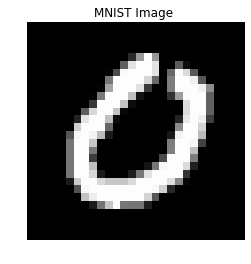

prediction is 0, label is 0, matched: True


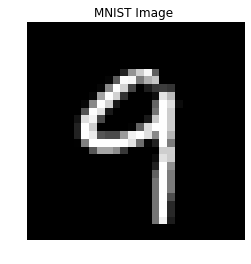

prediction is 9, label is 9, matched: True


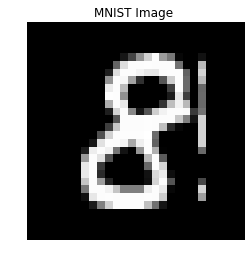

prediction is 8, label is 8, matched: True


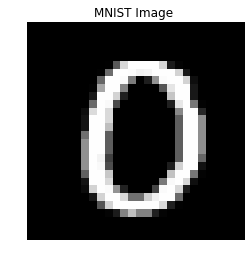

prediction is 0, label is 0, matched: True


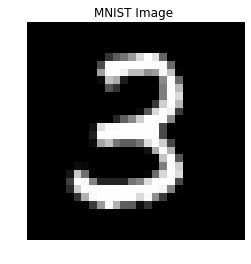

prediction is 3, label is 3, matched: True


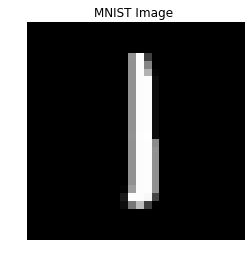

prediction is 1, label is 1, matched: True


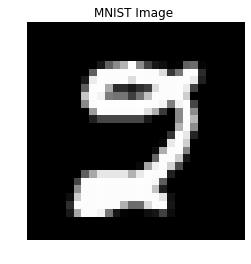

prediction is 3, label is 2, matched: False


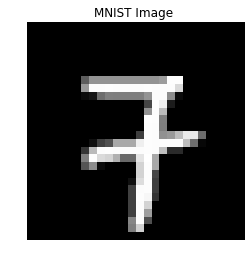

prediction is 7, label is 7, matched: True


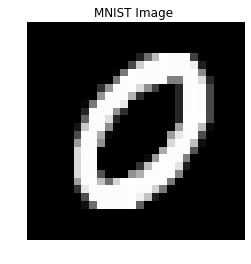

prediction is 0, label is 0, matched: True


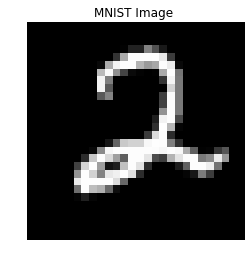

prediction is 2, label is 2, matched: True


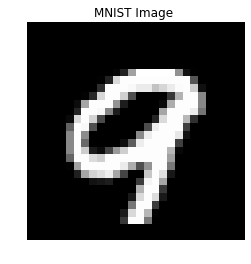

prediction is 9, label is 9, matched: True


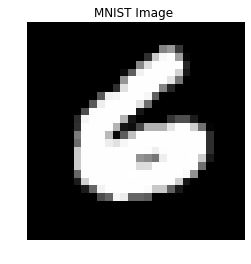

prediction is 6, label is 6, matched: True


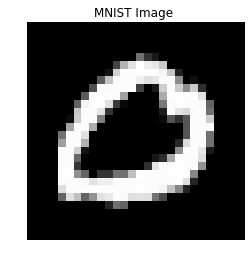

prediction is 0, label is 0, matched: True


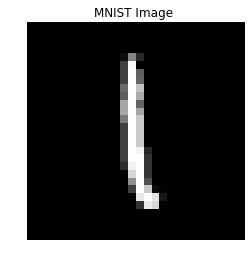

prediction is 1, label is 1, matched: True


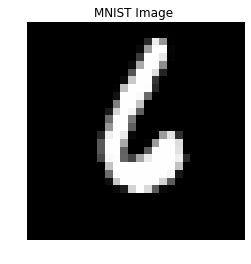

prediction is 6, label is 6, matched: True


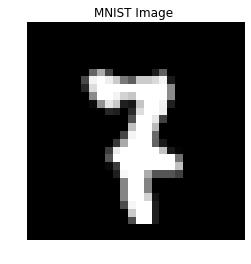

prediction is 7, label is 7, matched: True


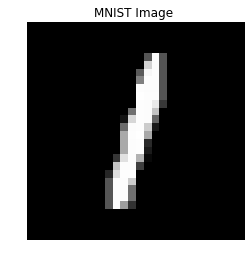

prediction is 1, label is 1, matched: True


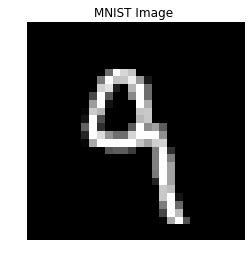

prediction is 9, label is 9, matched: True


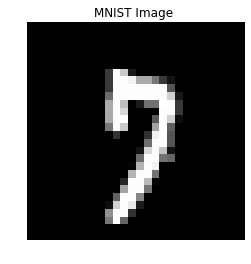

prediction is 7, label is 7, matched: True


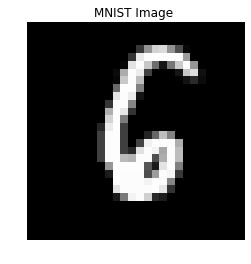

prediction is 6, label is 6, matched: True


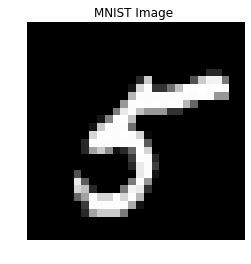

prediction is 5, label is 5, matched: True


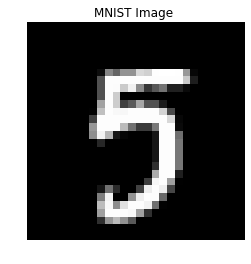

prediction is 5, label is 5, matched: True


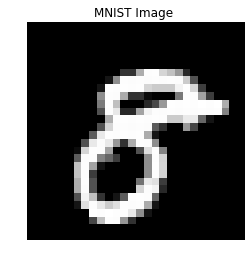

prediction is 8, label is 8, matched: True


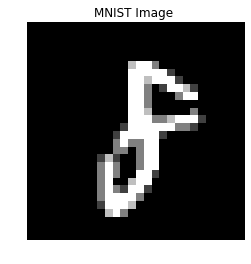

prediction is 8, label is 8, matched: True


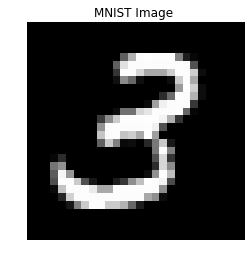

prediction is 3, label is 3, matched: True


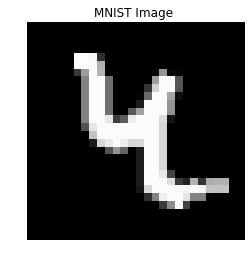

prediction is 4, label is 4, matched: True


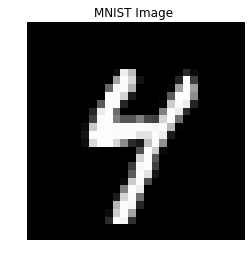

prediction is 4, label is 4, matched: True


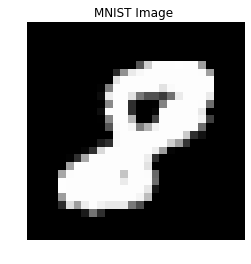

prediction is 8, label is 8, matched: True


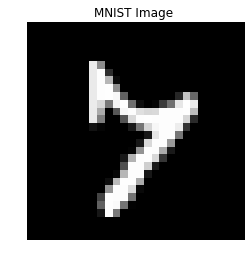

prediction is 7, label is 7, matched: True


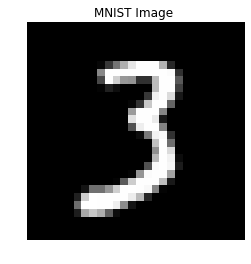

prediction is 3, label is 3, matched: True


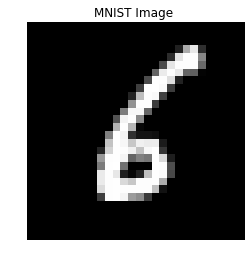

prediction is 6, label is 6, matched: True


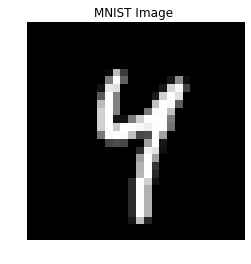

prediction is 4, label is 4, matched: True


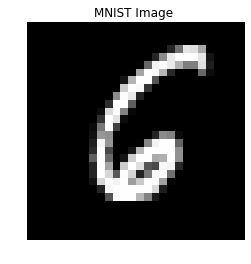

prediction is 6, label is 6, matched: True


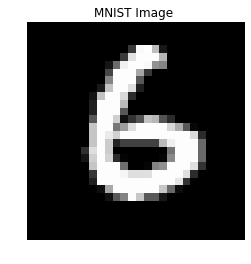

prediction is 6, label is 6, matched: True


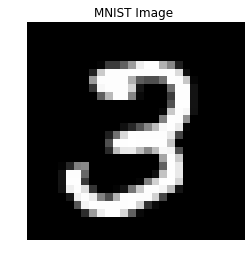

prediction is 3, label is 3, matched: True


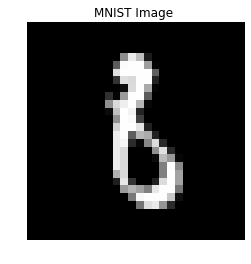

prediction is 8, label is 8, matched: True


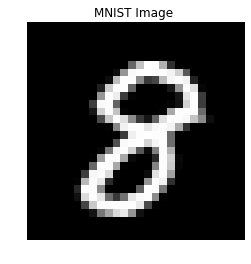

prediction is 8, label is 8, matched: True


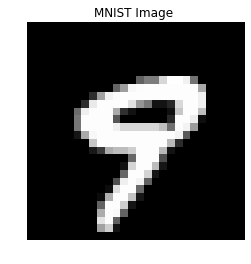

prediction is 9, label is 9, matched: True


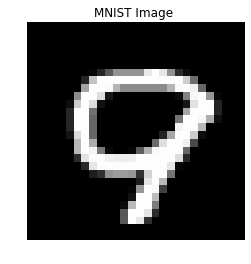

prediction is 9, label is 9, matched: True


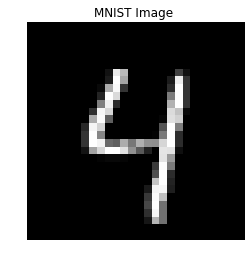

prediction is 4, label is 4, matched: True


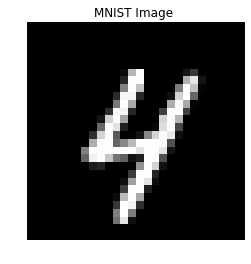

prediction is 4, label is 4, matched: True


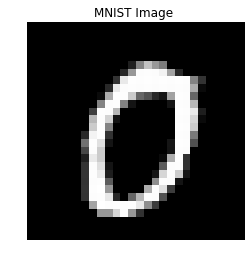

prediction is 0, label is 0, matched: True


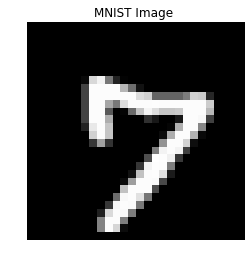

prediction is 7, label is 7, matched: True


In [31]:
predictions2 = predictor2.predict(train_data[:50])
for i in range(0, 50):
    prediction = predictions2['predictions'][i]
    max_prob_prediction=(prediction.index(max(prediction)))
    mnist_image=train_data[i].reshape((28,28))
    plot_mnist(mnist_image)
    label = train_labels[i]
    print('prediction is {}, label is {}, matched: {}'.format(max_prob_prediction, label, max_prob_prediction == label))
    

# Delete the endpoint

Let's delete the endpoint we just created to prevent incurring any extra costs.

In [28]:
#sagemaker.Session().delete_endpoint(predictor.endpoint)

Delete the TensorFlow 2.0 endpoint as well.

In [29]:
#sagemaker.Session().delete_endpoint(predictor2.endpoint)